# Use SurvivalEVAL for scikit-survival model

In this notebook we introduce the use of `ScikitSurvivalEvaluator` in the package to evaluate the performance for a scikit-survival model.
The first half of this notebook follows the procedure described in the Scikit-Survival [example](https://github.com/havakv/pycox/blob/master/examples/01_introduction.ipynb).


In the following, we will:
1. Load the German Breast Cancer Study Group 2 dataset;
2. Train the `CoxPH` model using 70% of the data;
3. Perform evaluation on the 30% testing set.

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import check_y_survival

from Evaluator import ScikitSurvivalEvaluator

In [2]:
%matplotlib inline

## Load and prepare data.

In [3]:
X, y = load_gbsg2()
X.loc[:, "tgrade"] = X.loc[:, "tgrade"].map(len).astype(int)
Xt = OneHotEncoder().fit_transform(X)

In [4]:
n = len(Xt)

tr_size = int(n*0.70)

Xt_train, Xt_test = Xt.iloc[:tr_size, :], Xt.iloc[tr_size:, :]
y_train, y_test = y[:tr_size], y[tr_size:]
train_event_indicators, train_event_times = check_y_survival(y_train)
test_event_indicators, test_event_times = check_y_survival(y_test)


## Build the model and train it.

In [5]:
est = CoxPHSurvivalAnalysis(ties="efron").fit(Xt_train, y_train)

## Predict individual survival functions
Get probability of remaining event free from 1 year to 5 years (=1825 days).

In [6]:
survs = est.predict_survival_function(Xt_test)

## Build the evaluator.
Some arguments includes:
1. Training set information (`durations_train` and `events_train`) is optional if you don't need Brier score, integrated Brier score, and L1-margin loss.
2. `predicted_time_method` argument indicates whether using median or mean survival time as the predicted time.

In [7]:
eval = ScikitSurvivalEvaluator(survs, test_event_times, test_event_indicators, train_event_times, train_event_indicators, predict_time_method="Median")

## Calculate the concordance index.
`ties` argument indicates the way ties should be handled.
`ties="None"` will throw out all ties in true survival time and all ties in predict survival times (risk scores).
`ties="Time"` includes ties in true survival time but removes ties in predict survival times (risk scores).
`ties="Risk"` includes ties in predict survival times (risk scores) but not in true survival time.
`ties="All"` includes all ties.

In [8]:
cindex, concordant_pairs, total_pairs = eval.concordance(ties="None")
print("Concordance index is {}, meaning that the model can correctly order {} pairs among {} comparable pairs "
      "in the testing set.".format(cindex, concordant_pairs, total_pairs))

Concordance index is 0.6612887062831947, meaning that the model can correctly order 6599.0 pairs among 9979.0 comparable pairs in the testing set.


## Calculate the Brier score
Target time is at time 175. You could use any time as preferred.

In [9]:
bs = eval.brier_score(target_time=175)
print("Brier score at time 175 is {}.".format(bs))

Brier score at time 175 is 0.009235037097327974.


## Calculate the integrated Brier score (IBS)
You can specify the number of points `num_points` to integral. If it is not specify, the default setting will use the censored time points obtained from testing set.

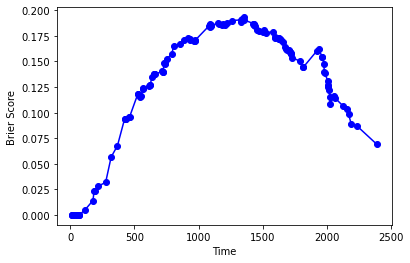

Integrated Brier score is 0.12827381547056485.


In [10]:
ibs = eval.integrated_brier_score(num_points=None, draw_figure=True)
print("Integrated Brier score is {}.".format(ibs))

# Calculate the L1-margin (MAE-margin) loss
You can set `method` as `Hinge`, `Uncensored`, `Margin`, `IPCW-v1`, `IPCW-v2`, or `Pseudo_obs` for different l1 loss calculation.

In [11]:
l1 = eval.l1_loss(method='Margin')
print("L1-margin loss is {}.".format(l1))

L1-margin loss is 1393.0816773738882.


## Calculate the 1-Calibration
Run one calibration test at 50% time of the testing set.

In [12]:
t_time = round(np.percentile(test_event_times, 50))
p_value, ob, exp = eval.one_calibration(target_time=t_time, method="DN")
if p_value >= 0.05:
    print("The model is one-calibrated at time {}.".format(t_time))
else:
    print("The model is not one-calibrated at time {}.".format(t_time))

The model is one-calibrated at time 858.


###  Plot the histogram for 1-Calibration.
As presented in [Effective Ways to Build and Evaluate Individual Survival Distributions](https://jmlr.csail.mit.edu/papers/v21/18-772.html)

In [13]:
# Reverse the bins to let it start from small to large observations
ob.reverse()
exp.reverse()

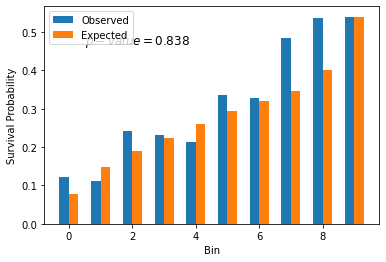

In [14]:
bins = np.arange(10)
plt.bar(bins - 0.15, ob, width=0.3, label="Observed")
plt.bar(bins + 0.15, exp, width=0.3, label="Expected")

plt.xlabel('Bin')
plt.ylabel('Survival Probability')
plt.text(0.5, 0.5, r'$p-value = {:.3f}$'.format(p_value), verticalalignment='top', horizontalalignment='left', fontsize=12, color='Black')
plt.legend()
plt.show()

## Calculate the distribution calibration (D-Calibration)

In [15]:
p_value_2, bin_statistics = eval.d_calibration()
if p_value_2 >= 0.05:
    print("The model is d-calibrated!")
else:
    print("The model is not d-calibrated!")

The model is d-calibrated!


In [16]:
# An ideal model should have bin statistics equally distributed. That means 0.1 for each value since we are using 10 bins.
bin_statistics /= bin_statistics.sum()
bin_statistics

array([0.11772446, 0.10876726, 0.09986195, 0.09651766, 0.10408213,
       0.08713236, 0.09791648, 0.09659758, 0.09812724, 0.09327287])

### Plot the sideways histogram of D-Calibration
As presented in [Effective Ways to Build and Evaluate Individual Survival Distributions](https://jmlr.csail.mit.edu/papers/v21/18-772.html)

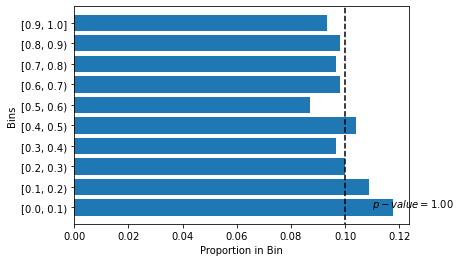

In [17]:
bars = ('[0.0, 0.1)', '[0.1, 0.2)', '[0.2, 0.3)', '[0.3, 0.4)', '[0.4, 0.5)',
        '[0.5, 0.6)', '[0.6, 0.7)', '[0.7, 0.8)', '[0.8, 0.9)', '[0.9, 1.0]')
y_pos = np.arange(len(bars))

fig, ax = plt.subplots()
ax.barh(y_pos, bin_statistics)
ax.plot(np.ones(len(bars)+2) * 0.1, np.arange(-1, len(bars)+1),  '--', color="black")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Proportion in Bin')
ax.set_ylabel('Bins')
ax.text(0.14, 0.5, r'$p-value = {:.2f}$'.format(p_value_2), verticalalignment='top', horizontalalignment='right', fontsize=10, color='Black')
plt.ylim([-0.8, 9.8])
plt.yticks(y_pos, bars)
plt.show()

### Plot the Q-Q plot of D-Calibration
As presented in [Countdown Regression: Sharp and Calibrated Survival Predictions](https://proceedings.mlr.press/v115/avati20a.html) and [Inverse-Weighted Survival Games](https://arxiv.org/abs/2111.08175)

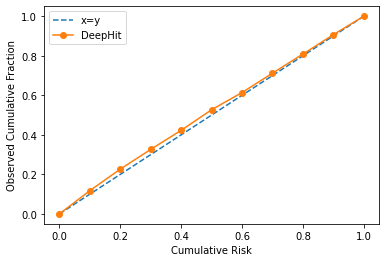

In [18]:
default = np.linspace(0, 1, 11)
plt.plot(default, default, linestyle='dashed', label="x=y")

fraction = np.concatenate((np.array([0]), bin_statistics))
plt.plot(default, fraction.cumsum(), 'o-', label="DeepHit")

plt.xlabel("Cumulative Risk")
plt.ylabel("Observed Cumulative Fraction")
plt.legend()
plt.show()